In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import streamlit as st
import json
from dotenv import load_dotenv
from huggingface_hub import InferenceClient
import os

In [116]:
import sys
sys.path.append("./utils") 
import importlib

import search_utils
importlib.reload(search_utils)
from search_utils import *

In [6]:
london_listings = pd.read_csv('data/raw/ldn-listings.csv')
london_reviews = pd.read_csv('data/raw/ldn-reviews.csv')

amsterdam_listings = pd.read_csv('data/raw/ams-listings.csv')
amsterdam_reviews = pd.read_csv('data/raw/ams-reviews.csv')

barcelona_listings = pd.read_csv('data/raw/bar-listings.csv')
barcelona_reviews = pd.read_csv('data/raw/bar-reviews.csv')

rome_listings = pd.read_csv('data/raw/rome-listings.csv')
rome_reviews = pd.read_csv('data/raw/rome-reviews.csv')

In [7]:
listings = {
    "london": london_listings,
    "amsterdam": amsterdam_listings,
    "barcelona": barcelona_listings,
    "rome": rome_listings
}

reviews = {
    "london": london_reviews,
    "amsterdam": amsterdam_reviews,
    "barcelona": barcelona_reviews,
    "rome": rome_reviews
}

In [ ]:
for city, df in listings.items():
    print(city, len(df.columns))

london 79
amsterdam 79
barcelona 79
rome 79


In [9]:
base_cols = set(listings["london"].columns)

for city, df in listings.items():
    diff = base_cols.symmetric_difference(set(df.columns))
    print(city, diff)

london set()
amsterdam set()
barcelona set()
rome set()


First, I confirm that the columns are consistent across the datasets for each city - specifically checking if there are any city-specific extra columns or missing values. The outputs of the cells above demonstrate that:

1. All four cities have 79 columns, so the datasets are structurally identical.

2. When we compared to London, the symmetric difference is empty for Amsterdam, Barcelona, and Paris, meaning that there are no missing or extra columns in those cities.

In [10]:
for city_name, df in listings.items():
    df["city"] = city_name.lower()

all_listings = pd.concat(listings.values(), ignore_index=True)

### Clean Price Column

Looking at the price data, I realize that cities have some missing values. As a result, I decide to drop the datapoints with missing price values across all cities.

In [11]:
all_listings.groupby('city')['price'].agg(lambda x: x.isna().sum())

city
amsterdam     4606
barcelona     4134
london       34908
rome          4088
Name: price, dtype: int64

In [12]:
all_listings["price"] = all_listings["price"].apply(lambda x: float(str(x).replace("$","").replace(",","")) if pd.notna(x) else np.nan)
all_listings.dropna(subset=["price"], inplace=True)

print("Listings remaining after dropping missing prices")
all_listings.groupby('city').count().iloc[:, 0]

Listings remaining after dropping missing prices


city
amsterdam     5874
barcelona    15276
london       61963
rome         33564
Name: id, dtype: int64

### Clean Amenities Column

In [13]:
all_listings["amenities"] = all_listings["amenities"].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
all_listings["amenities"] = all_listings["amenities"].apply(lambda x: [a.lower().strip() for a in x])

In [14]:
unique_amenity_counts = {}

for amenities in all_listings["amenities"]:
    for amenity in amenities:
        unique_amenity_counts[amenity] = unique_amenity_counts.get(amenity, 0) + 1

print(f"Total unique amenities across all cities: {len(unique_amenity_counts)}")

Total unique amenities across all cities: 12938


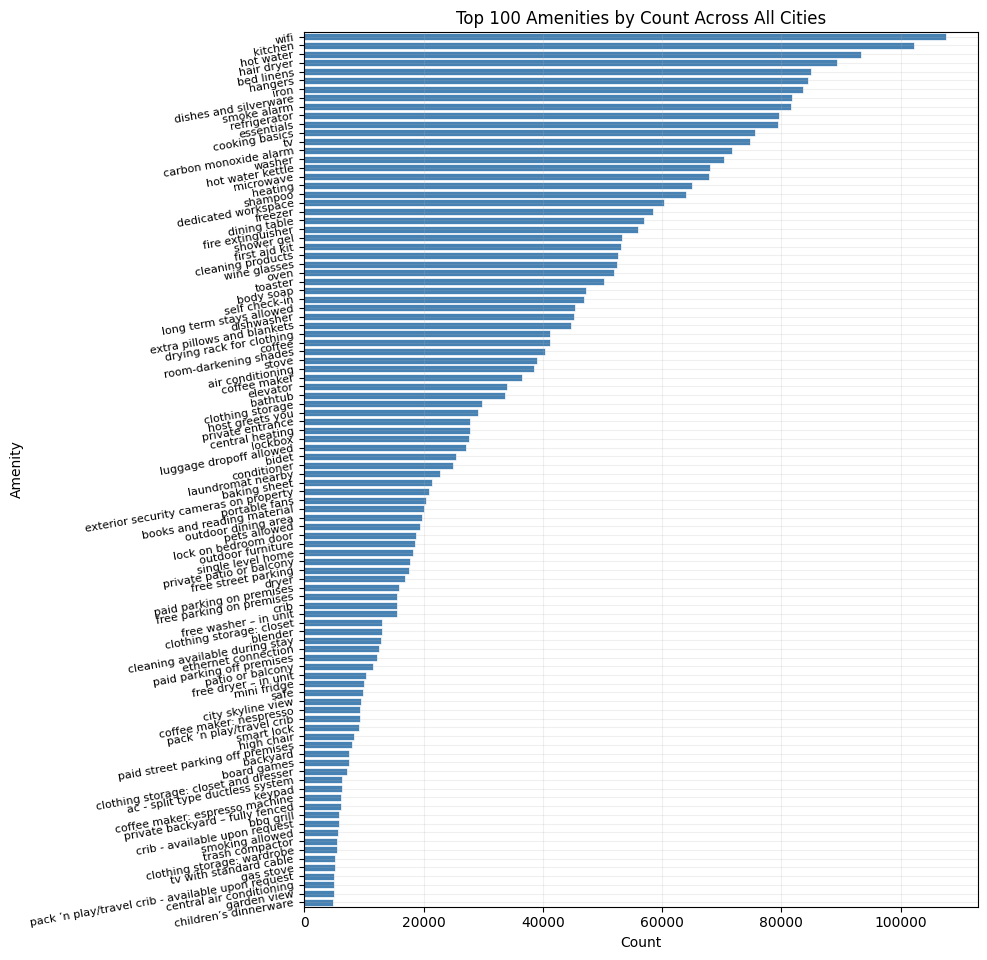

In [15]:
sorted_amenities_100 = sorted(unique_amenity_counts.items(), key=lambda x: x[1], reverse=True)[:100]
amenities = [a for a, _ in sorted_amenities_100]
counts = [c for _, c in sorted_amenities_100]

fig, ax = plt.subplots(figsize=(10, 10))
fig_height = max(15, len(amenities) * 0.22)
bars = ax.barh(amenities, counts, color="steelblue", edgecolor="white", linewidth=0.5)
ax.invert_yaxis()
ax.set_xlabel("Count")
ax.set_ylabel("Amenity")
ax.set_title("Top 100 Amenities by Count Across All Cities")
ax.tick_params(axis="y", labelsize=8)
ax.margins(y=0.005)
ax.set_ylim(len(amenities) - 0.5, -0.5)
plt.subplots_adjust(left=0.35)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.yticks(rotation=10, ha='right')
plt.grid(alpha=0.2)
plt.show()

In [16]:
for amenity in key_amenities:
    col_name = amenity.replace(" ", "_").replace("–", "-")
    all_listings[col_name] = all_listings["amenities"].apply(lambda x: 1 if amenity in x else 0)

## 2. Semantic Similarity

In [17]:
def textEmbeddings(row):
    fields = [
        str(row.get("name", "")),
        str(row.get("description", "")),
        str(row.get("neighborhood_overview", ""))
    ]
    return " ".join(fields)

all_listings["embedding_text"] = all_listings.apply(textEmbeddings, axis=1)

In [20]:
embeddings = embedder.encode(
    all_listings["embedding_text"].tolist(),
    show_progress_bar=True
)

all_listings["description_embedding"] = [np.array(e) for e in embeddings]

Batches: 100%|██████████| 3647/3647 [02:53<00:00, 21.02it/s] 


## Ranking and Scoring for Embedded System

In [21]:
all_listings['description'] = all_listings['description'].fillna("")

all_listings['description_embedding'] = all_listings['description'].apply(
    lambda x: np.array(embed_query(x))
)

In [42]:
all_listings.to_pickle("data/processed/all_listings.pkl")

## Translator LLM Chatbot

User

Streamlit UI (chat + sliders)

LLM (intent extraction)

Structured filters + semantic embeddings

Ranking engine

Top listings + explanations


In [29]:
query = "2-bedroom apartment in Paris under $200 with WiFi and washer"
print(extract_intent(query))

{'location': 'Paris', 'max_price': 200.0, 'amenities': ['wifi', 'washer']}


In [30]:
query = "Quiet 2-bedroom flat in London with washer, good WiFi, under £180 per night"
print(extract_intent(query))

{'location': 'london', 'max_price': 180.0, 'amenities': ['washer', 'good wifi']}


In [ ]:
user_query = "Quiet 2-bedroom flat in London with washer, good WiFi, under £180 per night"

top_results = search_listings(all_listings, user_query, key_amenities)

top_results[["city", "name", "price", "amenities", "score"]]

Intent extracted: {'location': 'london', 'max_price': 180.0, 'amenities': ['washer', 'good wifi']}
Location Filter (61963, 99)
Price Filter (40737, 99)


In [117]:
user_query = "3-bedroom cottage with a hot tub and garden"

top_results = search_listings(all_listings, user_query, key_amenities)

top_results[["city", "name", "price", "amenities", "score"]]

Intent extracted: {'location': '""', 'max_price': None, 'amenities': ['hot tub', 'garden']}


,city,name,price,amenities,score
12865,london,Contemporary two bed Queens Park house,270.0,"[self check-in, kitchen, cleaning products, ou...",0.705278
69183,london,Two bedroom cosy cottage,720.0,"[first aid kit, washer, tv, kitchen, free park...",0.691092
57266,london,Family Cozy Private Cottage,117.0,"[lamona refrigerator, self check-in, kitchen, ...",0.689462
137896,rome,"Monica & Mauro's House Vatican, Colosseum and ...",129.0,"[hangers, exterior security cameras on propert...",0.688832
53356,london,Beautiful Quiet House with Large Pretty Garden,364.0,"[self check-in, kitchen, cleaning products, ou...",0.688566
48686,london,Home in London,174.0,"[kitchen, outdoor dining area, smoke alarm, bb...",0.679531
73934,london,Coombe Cottage,73.0,"[clothing storage: wardrobe, kitchen, outdoor ...",0.671484
35886,london,Cosy Victorian cottage,32.0,"[kitchen, outdoor dining area, smoke alarm, bb...",0.667273
34932,london,Elegant 'Country House' in London with hot tub,475.0,"[safe, free driveway parking on premises – 3 s...",0.664982
2695,london,Luxury 120sqmt 2 bed garden Primrose Hill,433.0,"[self check-in, kitchen, cleaning products, ou...",0.659895
